In [ ]:
"""
Task 1: Sentiment Analysis of News Headlines
Author: Birhanu Berihun

This notebook reads financial news headlines from CSV,
performs sentiment analysis using TextBlob and NLTK's VADER,
and outputs daily average sentiment scores.

Output: ../data/outputs/daily_sentiment.csv
"""

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from pathlib import Path
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
from datetime import datetime


In [ ]:
sns.set(style='darkgrid')

[INFO] Dropped 1351341 invalid rows during preprocessing.
=== Descriptive Statistics ===
Headline Length Statistics:
count    55987.000000
mean        80.015254
std         56.126094
min         12.000000
25%         42.000000
50%         63.000000
75%         91.000000
max        512.000000
Name: headline_length, dtype: float64

Articles per Publisher:
publisher
Benzinga Newsdesk    14750
Lisa Levin           12408
ETF Professor         4362
Paul Quintaro         4212
Benzinga Newsdesk     3177
Benzinga Insights     2332
Vick Meyer            2128
Charles Gross         1790
Hal Lindon            1470
Benzinga_Newsdesk     1239
Name: count, dtype: int64

Articles per Date:
date
2011-04-28    3
2011-04-29    2
2011-04-30    1
2011-05-01    1
2011-05-02    9
2011-05-03    3
2011-05-05    3
2011-05-06    3
2011-05-07    1
2011-05-08    1
dtype: int64

=== Plotting Distributions and Trends ===


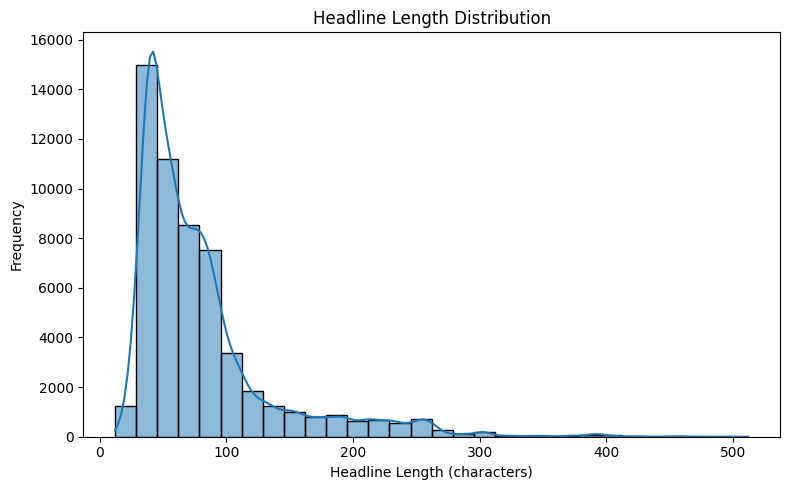

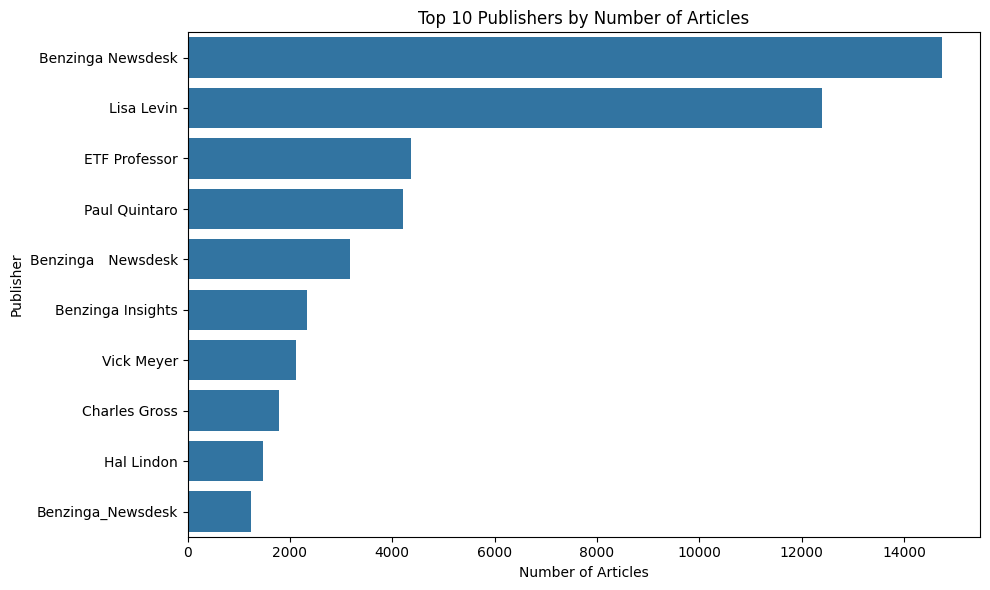

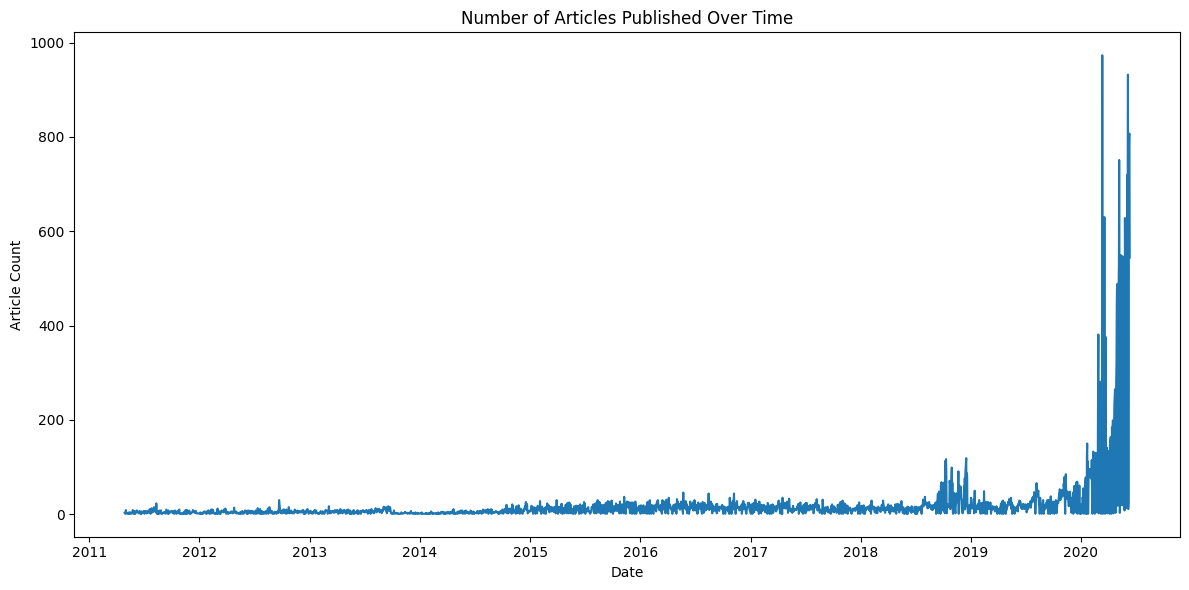

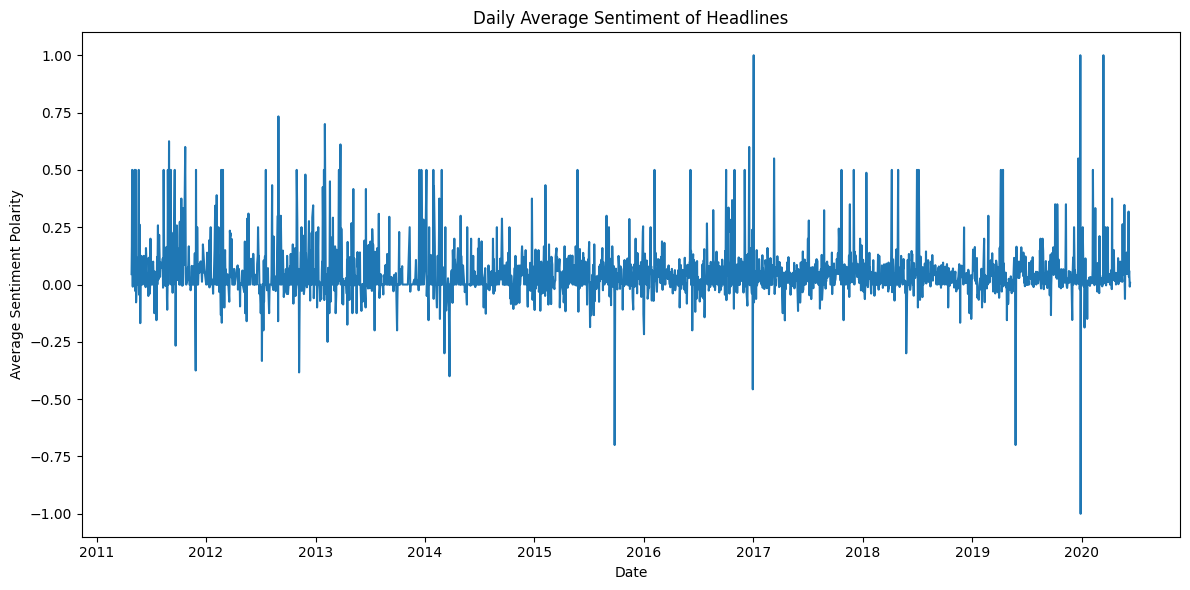

[INFO] Saved daily sentiment to ../data/daily_sentiment.csv

=== Topic Modeling (Top 5 Topics) ===
Topic 0: ['eps', 'sales', 'estimate', 'session', 'moving', 'stocks', 'q1', 'vs', 'yoy', 'est']
Topic 1: ['price', 'target', 'maintains', 'raises', 'downgrades', 'lowers', 'buy', 'benzinga', '2020', 'upgrades']
Topic 2: ['shares', 'etfs', 'market', 'update', 'etf', 'mid', 'announces', 'higher', 'reports', 'trading']
Topic 3: ['stocks', 'week', '52', 'hit', 'companies', 'trading', 'shares', 'lows', 'higher', 'amid']
Topic 4: ['new', 'yesterday', 'stocks', 'biggest', 'week', '52', 'set', 'movers', 'low', '2018']


In [6]:
class NewsSentimentAnalyzer:
    def __init__(self, csv_path):
        self.csv_path = Path(csv_path)
        self.df = pd.read_csv(self.csv_path)
    
    def preprocess(self):
        original_count = len(self.df)
        # Step 1: Convert date with error handling
        #self.df['date'] = pd.to_datetime(self.df['date'], format='mixed', errors='coerce')
        #print(f"[DEBUG] dtype of 'date': {self.df['date'].dtype}")
        #print(f"[DEBUG] sample dates:\n{self.df['date'].head(10)}")
        self.df['date'] = pd.to_datetime(self.df['date'], errors='coerce', utc=True)
        # Step 2: Drop rows where date or headline is missing
        #self.df = self.df.dropna(subset=['headline', 'date'])
        self.df = self.df.dropna(subset=['headline', 'date'])
        self.df['date'] = self.df['date'].dt.date


        # Step 3: Confirm it's datetime and extract date
        
        self.df['headline_length'] = self.df['headline'].apply(len)

        # Step 4: Reporting
        cleaned_count = len(self.df)
        print(f"[INFO] Dropped {original_count - cleaned_count} invalid rows during preprocessing.")



    def extract_domain(self, publisher):
        if '@' in publisher:
            return publisher.split('@')[1]
        return publisher
    
    def compute_sentiment(self):
        self.df['sentiment'] = self.df['headline'].apply(
            lambda text: TextBlob(text).sentiment.polarity
        )
    
    def descriptive_stats(self):
        print("Headline Length Statistics:")
        print(self.df['headline_length'].describe())
        print("\nArticles per Publisher:")
        print(self.df['publisher'].value_counts().head(10))
        #print("\nArticles per Publisher Domain:")
        #print(self.df['publisher_domain'].value_counts().head(10))
        print("\nArticles per Date:")
        print(self.df.groupby('date').size().head(10))
    
    def daily_average_sentiment(self):
        return self.df.groupby('date')['sentiment'].mean().reset_index()

    def publication_frequency_over_time(self):
        freq = self.df.groupby('date').size().reset_index(name='article_count')
        return freq
    def aggregate_daily_sentiment(self):
        daily_sentiment = self.df.groupby('date')['sentiment'].mean().reset_index()
        daily_sentiment.to_csv('../data/daily_sentiment.csv', index=False)
        print("[INFO] Saved daily sentiment to ../data/daily_sentiment.csv")
    
    def publication_hour_analysis(self):
        self.df['hour'] = self.df['date'].dt.hour
        hour_counts = self.df.groupby('hour').size().reset_index(name='article_count')
        return hour_counts
    
    def topic_modeling(self, n_topics=5, n_top_words=10):
        vectorizer = CountVectorizer(stop_words='english', max_features=1000)
        X = vectorizer.fit_transform(self.df['headline'])
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda.fit(X)
        feature_names = vectorizer.get_feature_names_out()
        topics = []
        for idx, topic in enumerate(lda.components_):
            top_features = [feature_names[i] for i in topic.argsort()[-n_top_words:][::-1]]
            topics.append((idx, top_features))
        return topics
    
    def plot_headline_length_distribution(self):
        plt.figure(figsize=(8,5))
        sns.histplot(self.df['headline_length'], bins=30, kde=True)
        plt.title('Headline Length Distribution')
        plt.xlabel('Headline Length (characters)')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    
    def plot_articles_per_publisher(self, top_n=10):
        top_publishers = self.df['publisher'].value_counts().nlargest(top_n)
        plt.figure(figsize=(10,6))
        sns.barplot(x=top_publishers.values, y=top_publishers.index)
        plt.title(f'Top {top_n} Publishers by Number of Articles')
        plt.xlabel('Number of Articles')
        plt.ylabel('Publisher')
        plt.tight_layout()
        plt.show()
    
    def plot_publication_frequency_over_time(self):
        freq = self.publication_frequency_over_time()
        plt.figure(figsize=(12,6))
        sns.lineplot(data=freq, x='date', y='article_count')
        plt.title('Number of Articles Published Over Time')
        plt.xlabel('Date')
        plt.ylabel('Article Count')
        plt.tight_layout()
        plt.show()
    
    def plot_publication_hour_distribution(self):
        hour_counts = self.publication_hour_analysis()
        plt.figure(figsize=(10,5))
        sns.barplot(x=hour_counts['hour'], y=hour_counts['article_count'])
        plt.title('Articles Published by Hour of Day')
        plt.xlabel('Hour of Day')
        plt.ylabel('Number of Articles')
        plt.tight_layout()
        plt.show()
    
    def plot_daily_average_sentiment(self):
        daily_sentiment = self.daily_average_sentiment()
        plt.figure(figsize=(12,6))
        sns.lineplot(data=daily_sentiment, x='date', y='sentiment')
        plt.title('Daily Average Sentiment of Headlines')
        plt.xlabel('Date')
        plt.ylabel('Average Sentiment Polarity')
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    analyzer = NewsSentimentAnalyzer('../data/raw_analyst_ratings.csv')
    analyzer.preprocess()
    analyzer.compute_sentiment()
    
    print("=== Descriptive Statistics ===")
    analyzer.descriptive_stats()
    
    print("\n=== Plotting Distributions and Trends ===")
    analyzer.plot_headline_length_distribution()
    analyzer.plot_articles_per_publisher()
    analyzer.plot_publication_frequency_over_time()
    #analyzer.plot_publication_hour_distribution()
    analyzer.plot_daily_average_sentiment()
    analyzer.aggregate_daily_sentiment()
    
    print("\n=== Topic Modeling (Top 5 Topics) ===")
    topics = analyzer.topic_modeling()
    for idx, top_words in topics:
        print(f"Topic {idx}: {top_words}")
